In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, train_test_split, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt

from category_encoders import MEstimateEncoder

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor


from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.decomposition import PCA
import seaborn as sns

import lightgbm as lgb
import statsmodels.api as sm
import math
import re
from optuna import trial
import optuna

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
pc_first = pd.read_csv('pc_first.csv')

In [5]:
sectors = pd.read_csv('sectors.csv')

In [6]:
population = pd.read_csv('population.csv')

In [4]:
roads = pd.read_csv('roads_network.csv')

In [4]:
def features(df):
    
    
    ## create date features
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df['Date'].apply(lambda x : x.month)
    df['year'] = df['Date'].apply(lambda x : x.year)
    df['day'] = df['Date'].apply(lambda x: x.day)
    
    
    
    
    # take the hour of time
    df['Time'].fillna(2, inplace=True)
    
    df['Time_hour'] = df['Time'].apply(lambda x : int(str(x).split(':')[0]))
    df['Time_split'] = df['Time'].apply(lambda x : int(str(x).split(':')[0])* 60 + int(str(x).split(':')[-1]))
    
    df["Time_norm"] = 2 * math.pi * df["Time_split"] / df["Time_split"].max()
    
    df["Time_cos"] = np.cos(df["Time_norm"])
    
    df["Time_sin"] = np.sin(df["Time_norm"])
    
    
    df['Month_norm'] = 2 * math.pi * df["Month"] / df["Month"].max()
    
    
    df['Month_cos'] = np.cos(df['Month_norm'])
    
    df['Month_sin'] = np.sin(df['Month_norm'])
    
    
    
    df['daylight'] = df['Time_split'].apply(lambda x : 1 if ((x>7) & (x<16)) else 0)
    
    df['winter'] = df['Month'].apply(lambda x: 1 if ((x == 11) or (x == 12) or (x == 1) or (x == 2) or (x==3)) else 0)
    
    #do one hot encoding for related features
    #df_cat = pd.get_dummies(df[cat_cols])
    
    #df_cat = df[te_cols]
    #df_cat['Number_of_Casualties'] = df['Number_of_Casualties']
    
    
    
    
    
    return df

In [5]:
train = features(train)
test = features(test)

In [10]:
train.columns

Index(['Accident_ID', 'Police_Force', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'state', 'postcode', 'country', 'Month', 'year', 'day', 'Time_split',
       'daylight', 'winter'],
      dtype='object')

In [6]:
train

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Time_hour,Time_split,Time_norm,Time_cos,Time_sin,Month_norm,Month_cos,Month_sin,daylight,winter
0,1,34,2,1,2012-12-19,7,13:20,344,E10000032,4,...,13,800,3.493084,-0.938860,-0.344299,6.283185,1.000000e+00,-2.449294e-16,0,1
1,2,5,2,1,2012-02-11,4,7:53,102,E09000026,3,...,7,473,2.065286,-0.474583,0.880211,1.047198,5.000000e-01,8.660254e-01,0,1
2,3,1,2,1,2012-02-11,4,16:00,531,E10000016,6,...,16,960,4.191701,-0.497477,-0.867477,1.047198,5.000000e-01,8.660254e-01,0,1
3,4,1,1,1,2012-06-05,1,16:50,7,E08000035,6,...,16,1010,4.410019,-0.297784,-0.954633,3.141593,-1.000000e+00,1.224647e-16,0,0
4,5,46,1,1,2012-06-30,3,13:25,519,E10000031,3,...,13,805,3.514916,-0.931120,-0.364712,3.141593,-1.000000e+00,1.224647e-16,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478736,599995,13,1,1,2012-09-28,6,16:35,199,E10000015,6,...,16,995,4.344524,-0.359624,-0.933097,4.712389,-1.836970e-16,-1.000000e+00,0,0
478737,599996,13,2,1,2012-01-23,4,20:45,211,E09000012,6,...,20,1245,5.436112,0.662179,-0.749345,0.523599,8.660254e-01,5.000000e-01,0,1
478738,599997,6,2,4,2012-05-15,6,10:45,80,E06000047,3,...,10,645,2.816299,-0.947557,0.319587,2.617994,-8.660254e-01,5.000000e-01,0,0
478739,599998,33,2,1,2012-09-10,2,11:22,321,E10000024,3,...,11,682,2.977854,-0.986625,0.163008,4.712389,-1.836970e-16,-1.000000e+00,0,0


In [9]:
def pc_split(df):
    

    pc = pd.Series(df, name='postcode')
    
    regex = "^(?:(?P<a1>[Gg][Ii][Rr])(?P<d1>) (?P<s1>0)(?P<u1>[Aa]{2}))|(?:(?:(?:(?P<a2>[A-Za-z])(?P<d2>[0-9]{1,2}))|(?:(?:(?P<a3>[A-Za-z][A-Ha-hJ-Yj-y])(?P<d3>[0-9]{1,2}))|(?:(?:(?P<a4>[A-Za-z])(?P<d4>[0-9][A-Za-z]))|(?:(?P<a5>[A-Za-z][A-Ha-hJ-Yj-y])(?P<d5>[0-9]?[A-Za-z]))))) (?P<s2>[0-9])(?P<u2>[A-Za-z]{2}))$"
    pc_parts = pc.str.extract(regex, re.IGNORECASE, expand=True)
    
    pc_parsed = pc.reset_index()
    pc_parsed['postcode_area'] = pd.concat([pc_parts[['a%s'%i]] for i in range(1,6)], axis=1).bfill(axis=1).iloc[:,0]
    pc_parsed['postcode_district_part'] = pd.concat([pc_parts[['d%s'%i]] for i in range(1,6)], axis=1).bfill(axis=1).iloc[:,0]
    pc_parsed['postcode_sector_part'] = pd.concat([pc_parts[['s%s'%i]] for i in range(1,3)], axis=1).bfill(axis=1).iloc[:,0]
    pc_parsed['postcode_district'] = pc_parsed['postcode_area'] + pc_parsed['postcode_district_part']
    pc_parsed['postcode_sector'] = pc_parsed['postcode_area'] + pc_parsed['postcode_district_part'] + ' ' + pc_parsed['postcode_sector_part']
    pc_parsed = pc_parsed[['postcode','postcode_area','postcode_district','postcode_sector']]
    
    
    
    
    return pc_parsed


<AxesSubplot:xlabel='high_risk_sector', ylabel='mean'>

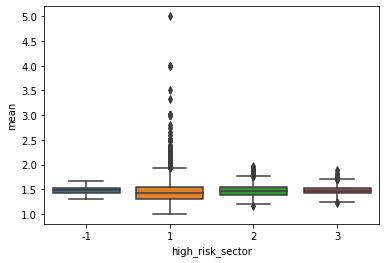

In [73]:
sns.boxplot(x='high_risk_sector', y='mean', data=sectors)

In [7]:
def _aggregate(df, new_df, on):
    
    _unique = list(df[on].unique())
    
    _unique = sorted(_unique)
    
    print(_unique)
    
    tmp = df.groupby(['postcode',on]).agg({'Accident_ID':np.count_nonzero}).unstack()
    
    tmp.columns = [str(on) + '_' + str(x) for x in _unique]
    
    tmp = tmp.reset_index(drop=True)
    tmp.fillna(0, inplace=True)
    new_df = new_df.join(tmp)
    
    return new_df

In [8]:
###aggregations
_aggs = {
          'Number_of_Casualties': [ np.mean],
          'Number_of_Vehicles':[np.min, np.max],
         'Accident_ID':np.count_nonzero,
         'Police_Force':[np.min,np.max,np.mean],
         'Speed_limit':[np.min, np.max],
        'Time_cos': [np.min, np.max, np.mean],
        'Time_sin': [np.min, np.max, np.mean],
        
        }


In [9]:
_agg_cols = ['postcode','Accident_risk_index','vehicle_min','vehicle_max','Accident_ID','police_min','police_max','police_mean','speed_min','speed_max','Time_cos_min','Time_cos_max','Time_cos_mean','Time_sin_min','Time_sin_max','Time_sin_mean']

In [10]:
train_df = train.groupby(['postcode']).agg(_aggs).reset_index()

In [11]:
train_df.columns = _agg_cols

In [12]:
test_df = test.groupby(['postcode']).agg(_aggs).reset_index()

In [13]:
test_df.columns = _agg_cols

In [14]:
test_df.shape, train_df.shape

((49772, 16), (95625, 16))

In [15]:
_unstack_cols = ['1st_Road_Class',                
                 #'Month',
                 'Urban_or_Rural_Area','winter','daylight',
                 'Did_Police_Officer_Attend_Scene_of_Accident',
                 
                ]

In [16]:
for i in _unstack_cols:
    train_df = _aggregate(train, train_df, i)
    test_df = _aggregate(test, test_df, i)

[1, 3, 4, 5, 6]
[1, 3, 4, 5, 6]
[1, 2]
[1, 2]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
['No', 'Yes']
['No', 'Yes']


In [24]:
sectors['high_risk_sector'] = 0

In [25]:
sectors.loc[(sectors['sum'] > 100) & (sectors['sum'] <= 200),'high_risk_sector'] = 3
sectors.loc[(sectors['sum'] > 65) & (sectors['sum'] <= 100),'high_risk_sector'] = 2
sectors.loc[(sectors['sum'] <= 65),'high_risk_sector'] = 1
sectors.loc[(sectors['sum'] > 200),'high_risk_sector'] = -1

In [26]:
sectors.loc[sectors.high_risk_sector == 0]

,sector,sum,min,max,mean,accidents,high_risk_sector


d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sum'>

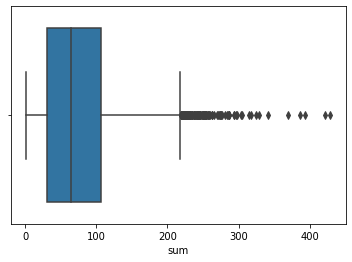

In [433]:
sns.boxplot(sectors['sum'])

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='high_risk_sector', ylabel='count'>

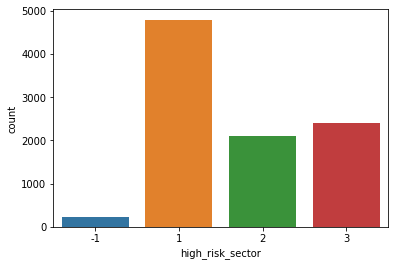

In [457]:
sns.countplot(sectors['high_risk_sector'])

In [434]:
sectors.describe()

,sum,min,max,mean,accidents,high_risk_sector
count,9519.000000,9519.000000,9519.000000,9519.000000,9519.000000,9519.0
mean,73.605526,1.008299,3.942116,1.458489,50.293203,0.0
std,54.046599,0.117024,1.132302,0.207787,36.628980,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
25%,31.000000,1.000000,3.000000,1.363636,21.000000,0.0
50%,65.000000,1.000000,4.000000,1.453125,45.000000,0.0
75%,106.000000,1.000000,5.000000,1.538462,72.000000,0.0
max,429.000000,5.000000,5.000000,5.000000,281.000000,0.0


In [27]:
tmp = pc_split(train_df['postcode'].values)
train_df = train_df.merge(tmp, on='postcode', how='left')

In [28]:
tmp = pc_split(test_df['postcode'].values)
test_df = test_df.merge(tmp, on='postcode', how='left')
test_df

,postcode,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,Urban_or_Rural_Area_2,winter_0,winter_1,daylight_0,daylight_1,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,postcode_area,postcode_district,postcode_sector
0,AB10 1AU,0.0,1,1,1,14,14,14.000000,30,30,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,AB,AB10,AB10 1
1,AB10 1PG,0.0,1,1,2,1,11,6.000000,30,60,...,1.0,1.0,1.0,1.0,1.0,0.0,2.0,AB,AB10,AB10 1
2,AB10 1TT,0.0,2,2,1,15,15,15.000000,30,30,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,AB,AB10,AB10 1
3,AB10 1YP,0.0,2,2,3,1,43,18.333333,20,30,...,0.0,2.0,1.0,0.0,3.0,1.0,2.0,AB,AB10,AB10 1
4,AB10 6LQ,0.0,2,2,1,47,47,47.000000,30,30,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,AB,AB10,AB10 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49767,ZE2 9LZ,0.0,2,2,1,1,1,1.000000,30,30,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,ZE,ZE2,ZE2 9
49768,ZE2 9RE,0.0,1,2,4,1,14,4.250000,30,40,...,0.0,4.0,0.0,2.0,2.0,0.0,4.0,ZE,ZE2,ZE2 9
49769,ZE2 9RJ,0.0,2,2,1,1,1,1.000000,30,30,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,ZE,ZE2,ZE2 9
49770,ZE2 9SB,0.0,2,2,1,15,15,15.000000,30,30,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,ZE,ZE2,ZE2 9


In [29]:
train_df = train_df.merge(population, left_on='postcode_sector', right_on='postcode', how='left')

In [30]:
test_df = test_df.merge(population, left_on='postcode_sector', right_on='postcode', how='left')

In [31]:
sectors['postcode_sector'] = sectors['sector'].apply(lambda x: x[:-1] + ' '+x[-1])

In [32]:
sectors

,sector,sum,min,max,mean,accidents,high_risk_sector,postcode_sector
0,AB101,96,1,4,1.391304,69,2,AB10 1
1,AB106,21,1,2,1.312500,16,1,AB10 6
2,AB107,84,1,5,1.473684,57,2,AB10 7
3,AB115,50,1,4,1.315789,38,1,AB11 5
4,AB116,97,1,4,1.539683,63,2,AB11 6
...,...,...,...,...,...,...,...,...
9514,YO88,121,1,5,1.390805,87,3,YO8 8
9515,YO89,112,1,4,1.435897,78,3,YO8 9
9516,YO901,9,1,3,1.800000,5,1,YO90 1
9517,ZE10,36,1,3,1.333333,27,1,ZE1 0


In [33]:
train_df = train_df.merge(sectors[['postcode_sector','high_risk_sector']], left_on='postcode_sector', right_on='postcode_sector', how='left')

In [34]:
test_df = test_df.merge(sectors[['postcode_sector','high_risk_sector']], left_on='postcode_sector', right_on='postcode_sector', how='left')

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='high_risk_sector', ylabel='count'>

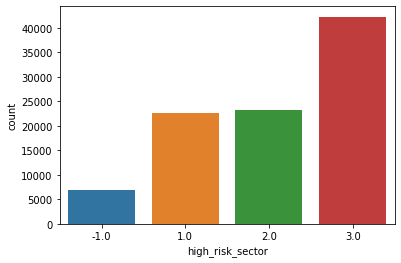

In [468]:
sns.countplot(train_df['high_risk_sector'])

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='high_risk_sector', ylabel='count'>

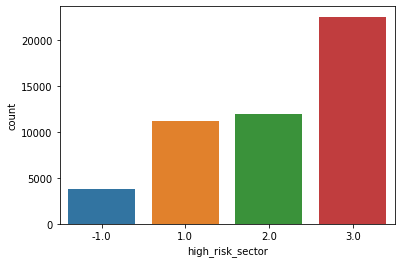

In [466]:
sns.countplot(test_df['high_risk_sector'])

In [154]:
len(test_predictions)

49772

In [18]:
train_df

,postcode,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,1st_Road_Class_5,1st_Road_Class_6,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2,winter_0,winter_1,daylight_0,daylight_1,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes
0,AB10 1AU,1.500000,1,2,4,22,46,38.750000,30,30,...,1.0,2.0,4.0,0.0,3.0,1.0,4.0,0.0,1.0,3.0
1,AB10 1BD,1.200000,1,2,5,4,93,41.200000,30,60,...,0.0,4.0,5.0,0.0,3.0,2.0,4.0,1.0,1.0,4.0
2,AB10 1BW,2.000000,1,2,4,1,44,18.000000,30,30,...,0.0,2.0,4.0,0.0,3.0,1.0,4.0,0.0,2.0,2.0
3,AB10 1HT,1.000000,1,2,3,13,35,20.333333,30,60,...,0.0,3.0,1.0,2.0,0.0,3.0,3.0,0.0,1.0,2.0
4,AB10 1NJ,1.428571,1,4,7,5,43,29.142857,30,60,...,1.0,1.0,2.0,5.0,5.0,2.0,7.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95620,ZE2 9QJ,1.500000,2,2,2,1,35,18.000000,30,60,...,1.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0
95621,ZE2 9QS,1.600000,1,2,5,1,61,23.200000,30,70,...,1.0,1.0,4.0,1.0,4.0,1.0,5.0,0.0,1.0,4.0
95622,ZE2 9RE,1.500000,2,3,2,1,43,22.000000,30,40,...,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0
95623,ZE2 9SB,1.400000,2,2,5,6,47,30.200000,30,50,...,1.0,1.0,2.0,3.0,3.0,2.0,5.0,0.0,2.0,3.0


In [484]:
test_df.loc[test_df.postcode_x == 'AB10 1AU']

,postcode_x,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value,high_risk_sector
0,AB10 1AU,0.0,1,1,1,14,14,14.0,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [17]:
X = train_df.drop(['postcode','Accident_risk_index'], axis=1)

#X.fillna(-999, inplace=True)

In [18]:
X

,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,Time_cos_min,Time_cos_max,...,1st_Road_Class_5,1st_Road_Class_6,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2,winter_0,winter_1,daylight_0,daylight_1,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes
0,1,2,4,22,46,38.750000,30,30,-0.907101,0.262156,...,1.0,2.0,4.0,0.0,3.0,1.0,4.0,0.0,1.0,3.0
1,1,2,5,4,93,41.200000,30,60,-0.866934,0.997856,...,0.0,4.0,5.0,0.0,3.0,2.0,4.0,1.0,1.0,4.0
2,1,2,4,1,44,18.000000,30,30,-0.767135,0.503148,...,0.0,2.0,4.0,0.0,3.0,1.0,4.0,0.0,2.0,2.0
3,1,2,3,13,35,20.333333,30,60,-0.689528,0.090478,...,0.0,3.0,1.0,2.0,0.0,3.0,3.0,0.0,1.0,2.0
4,1,4,7,5,43,29.142857,30,60,-0.995997,0.736929,...,1.0,1.0,2.0,5.0,5.0,2.0,7.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95620,2,2,2,1,35,18.000000,30,60,-0.952994,0.868020,...,1.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0
95621,1,2,5,1,61,23.200000,30,70,-0.924609,0.328880,...,1.0,1.0,4.0,1.0,4.0,1.0,5.0,0.0,1.0,4.0
95622,2,3,2,1,43,22.000000,30,40,-0.419923,-0.105686,...,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0
95623,2,2,5,6,47,30.200000,30,50,-0.640648,0.999962,...,1.0,1.0,2.0,3.0,3.0,2.0,5.0,0.0,2.0,3.0


In [19]:
centroid = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    print(f"silhoutte scores for k {k} ",silhouette_score(X, kmeans.labels_))
    centroid.append(np.sqrt(kmeans.inertia_))

silhoutte scores for k 2  0.42201626693073896
silhoutte scores for k 3  0.3958165658003293
silhoutte scores for k 4  0.40407283699031676
silhoutte scores for k 5  0.3892644060522355
silhoutte scores for k 6  0.40830030518253607
silhoutte scores for k 7  0.431402520899617
silhoutte scores for k 8  0.42278183598081404
silhoutte scores for k 9  0.4007623911083211


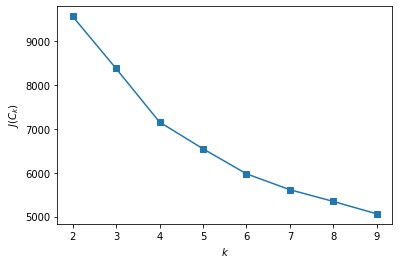

In [20]:
plt.plot(range(2, 10), centroid, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

In [21]:
kmeans = KMeans(n_clusters=5, n_init=100, max_iter=400,  random_state=42)

In [22]:
kmeans.fit(X)

KMeans(max_iter=400, n_clusters=5, n_init=100, random_state=42)

In [68]:
silhouette_score(X, kmeans.labels_)

0.754940388291082

In [23]:
train_df['labels'] = kmeans.labels_

In [24]:
x_test_labels = kmeans.predict(test_df.drop(['postcode','Accident_risk_index'], axis=1))

In [25]:
test_df['labels'] = x_test_labels

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

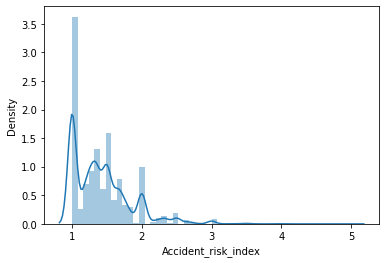

In [26]:
sns.distplot(train_df.loc[train_df['labels'] == 0,'Accident_risk_index'])

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

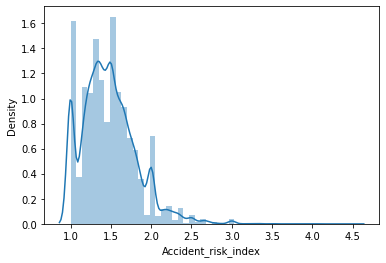

In [27]:
sns.distplot(train_df.loc[train_df['labels'] == 1,'Accident_risk_index'])

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

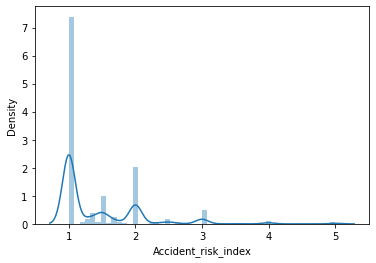

In [28]:
sns.distplot(train_df.loc[train_df['labels'] == 2,'Accident_risk_index'])

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

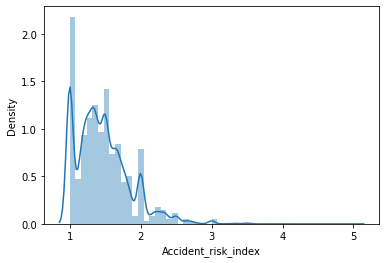

In [29]:
sns.distplot(train_df.loc[train_df['labels'] == 3,'Accident_risk_index'])

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

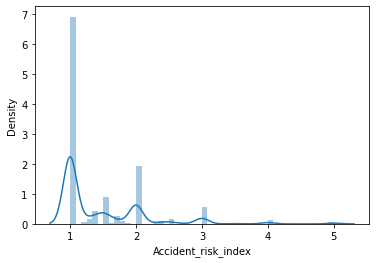

In [30]:
sns.distplot(train_df.loc[train_df['labels'] == 4,'Accident_risk_index'])

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Accident_ID', ylabel='count'>

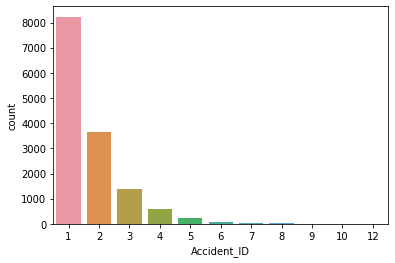

In [348]:
sns.countplot(train_df[train_df['labels']==0]['Accident_ID'])

In [138]:
train_df.loc[train_df['labels'] == 1]

,postcode,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,labels
10,AB10 1TP,2.000000,2,2,2,32,53,42.500000,40,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
11,AB10 1TX,1.000000,2,2,1,42,42,42.000000,30,30,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
22,AB10 7LF,2.000000,1,2,2,61,95,78.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
28,AB11 5AZ,1.000000,1,1,1,61,61,61.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
34,AB11 5PD,1.000000,1,3,3,61,62,61.666667,30,30,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95597,YO8 9FT,2.000000,2,2,1,43,43,43.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
95604,YO8 9UG,1.000000,1,2,2,42,61,51.500000,30,70,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
95610,ZE1 0HJ,1.000000,2,2,1,35,35,35.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
95616,ZE2 9LD,1.000000,1,1,1,42,42,42.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [214]:
train_df

,postcode,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,1st_Road_Class_5,1st_Road_Class_6,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2,winter_0,winter_1,daylight_0,daylight_1,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes
0,AB10 1AU,1.500000,1,2,4,22,46,38.750000,30,30,...,1.0,2.0,4.0,0.0,3.0,1.0,3.0,1.0,1.0,3.0
1,AB10 1BD,1.200000,1,2,5,4,93,41.200000,30,60,...,0.0,4.0,5.0,0.0,3.0,2.0,1.0,4.0,1.0,4.0
2,AB10 1BW,2.000000,1,2,4,1,44,18.000000,30,30,...,0.0,2.0,4.0,0.0,3.0,1.0,1.0,3.0,2.0,2.0
3,AB10 1HT,1.000000,1,2,3,13,35,20.333333,30,60,...,0.0,3.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0,2.0
4,AB10 1NJ,1.428571,1,4,7,5,43,29.142857,30,60,...,1.0,1.0,2.0,5.0,5.0,2.0,4.0,3.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95620,ZE2 9QJ,1.500000,2,2,2,1,35,18.000000,30,60,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0
95621,ZE2 9QS,1.600000,1,2,5,1,61,23.200000,30,70,...,1.0,1.0,4.0,1.0,4.0,1.0,3.0,2.0,1.0,4.0
95622,ZE2 9RE,1.500000,2,3,2,1,43,22.000000,30,40,...,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0
95623,ZE2 9SB,1.400000,2,2,5,6,47,30.200000,30,50,...,1.0,1.0,2.0,3.0,3.0,2.0,4.0,1.0,2.0,3.0


In [146]:
np.floor(1.5)

1.0

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

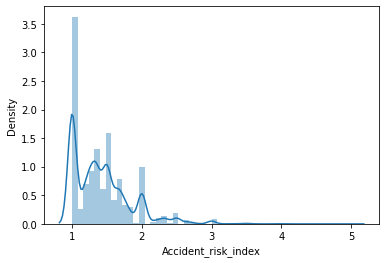

In [104]:
sns.distplot(train_df.loc[train_df['labels'] == 1,'Accident_risk_index'])

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

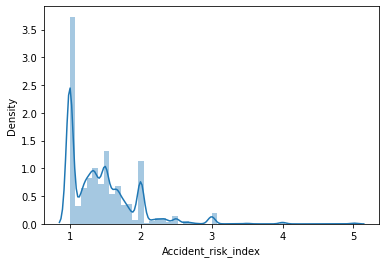

In [105]:
sns.distplot(train_tmp['Accident_risk_index'])

In [175]:
train_df.query("labels != 1 and labels != 4")['labels']

array([3, 2, 0])

In [173]:
train_df.query("labels == 1")

,postcode,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,labels
10,AB10 1TP,2.000000,2,2,2,32,53,42.500000,40,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
11,AB10 1TX,1.000000,2,2,1,42,42,42.000000,30,30,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
22,AB10 7LF,2.000000,1,2,2,61,95,78.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
28,AB11 5AZ,1.000000,1,1,1,61,61,61.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
34,AB11 5PD,1.000000,1,3,3,61,62,61.666667,30,30,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95597,YO8 9FT,2.000000,2,2,1,43,43,43.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
95604,YO8 9UG,1.000000,1,2,2,42,61,51.500000,30,70,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
95610,ZE1 0HJ,1.000000,2,2,1,35,35,35.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
95616,ZE2 9LD,1.000000,1,1,1,42,42,42.000000,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [31]:
X = train_df.drop(['postcode','Accident_risk_index','labels'], axis = 1)

In [32]:
x_test = test_df.drop(['postcode','Accident_risk_index','labels'], axis = 1)

In [33]:
pca2 = PCA(n_components=2).fit(X)
pca2d = pca2.transform(X)

In [34]:
#pca2 = PCA(n_components=2).fit(X)
pca3d = pca2.transform(x_test)

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


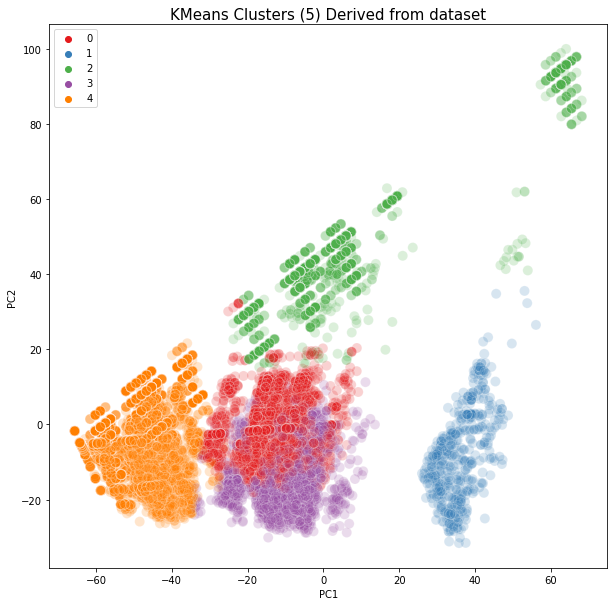

In [35]:
plt.figure(figsize = (10,10))
sns.scatterplot(pca3d[:,0], pca3d[:,1], 
                hue=x_test_labels, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (5) Derived from dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


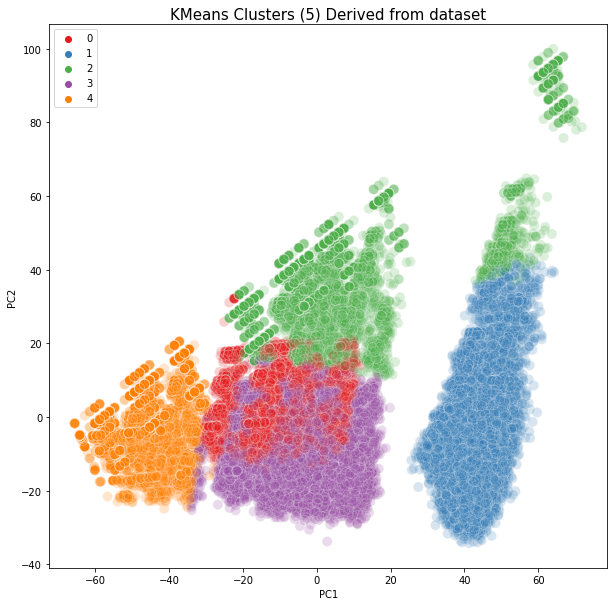

In [36]:
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=kmeans.labels_, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (5) Derived from dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [45]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [46]:
est = HistGradientBoostingRegressor(random_state=42)

In [47]:
distributions = {'learning_rate': [0.1,0.2,0.3, 0.01,0.02,0.03,0.5,0.04], 
                    'max_depth': [1,2,3,4,5,6,7,8,9,10,11], 'max_iter': [400,420,430,450,500,550], 
                    'max_leaf_nodes': [2,3,4,5,6,7,8,9,10], 'min_samples_leaf': [30,35,40,45,50], 
                    'l2_regularization': [0.2,0.25,0.3,0.35,0.40],
                    #'scoring':'neg_root_mean_squared_error',
                  }

In [48]:
clf = RandomizedSearchCV(est, distributions, n_iter=3, cv= kfold, scoring='neg_root_mean_squared_error', random_state=42)

In [41]:
x_train = train_df.drop(['postcode_x','Accident_risk_index', 'postcode_area',
       'postcode_district', 'postcode_sector','postcode_y','Rural Urban'],axis=1)
x_test = test_df.drop(['Accident_risk_index', 'postcode_area',
       'postcode_district', 'postcode_sector','postcode_y','Rural Urban'],axis=1)

In [42]:
x_train.columns = [ 'postcode_x','vehicle_min', 'vehicle_max',
       'Accident_ID', 'police_min', 'police_max', 'police_mean', 'speed_min',
       'speed_max', '1st_Road_Class_1', '1st_Road_Class_3', '1st_Road_Class_4',
       '1st_Road_Class_5', '1st_Road_Class_6', 'Urban_or_Rural_Area_1',
       'Urban_or_Rural_Area_2', 'winter_0', 'winter_1', 'daylight_0',
       'daylight_1', 'Did_Police_Officer_Attend_Scene_of_Accident_No',
       'Did_Police_Officer_Attend_Scene_of_Accident_Yes',  
       'All usual residents',
       'Males; measures',
       'Females; measures',
       'Lives in a household',
       'Lives in a communal establishment',
       'Schoolchild or full-time student aged 4 and over at their non term-time address',
       'Area_Hectares',
       'number of persons per hectare',
       'high_risk_sector']

x_test.columns = [ 'postcode_x','vehicle_min', 'vehicle_max',
       'Accident_ID', 'police_min', 'police_max', 'police_mean', 'speed_min',
       'speed_max', '1st_Road_Class_1', '1st_Road_Class_3', '1st_Road_Class_4',
       '1st_Road_Class_5', '1st_Road_Class_6', 'Urban_or_Rural_Area_1',
       'Urban_or_Rural_Area_2', 'winter_0', 'winter_1', 'daylight_0',
       'daylight_1', 'Did_Police_Officer_Attend_Scene_of_Accident_No',
       'Did_Police_Officer_Attend_Scene_of_Accident_Yes',  
       'All usual residents',
       'Males; measures',
       'Females; measures',
       'Lives in a household',
       'Lives in a communal establishment',
       'Schoolchild or full-time student aged 4 and over at their non term-time address',
       'Area_Hectares',
       'number of persons per hectare',
       'high_risk_sector']

In [39]:
train_df

,postcode_x,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value,high_risk_sector
0,AB10 1AU,1.500000,1,2,4,22,46,38.750000,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,AB10 1BD,1.200000,1,2,5,4,93,41.200000,30,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,AB10 1BW,2.000000,1,2,4,1,44,18.000000,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,AB10 1HT,1.000000,1,2,3,13,35,20.333333,30,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,AB10 1NJ,1.428571,1,4,7,5,43,29.142857,30,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95620,ZE2 9QJ,1.500000,2,2,2,1,35,18.000000,30,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
95621,ZE2 9QS,1.600000,1,2,5,1,61,23.200000,30,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
95622,ZE2 9RE,1.500000,2,3,2,1,43,22.000000,30,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
95623,ZE2 9SB,1.400000,2,2,5,6,47,30.200000,30,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [50]:
_cols = ['police_mean','police_min',
             'Schoolchild or full-time student aged 4 and over at their non term-time address',
             'police_max',
             'Lives in a communal establishment',
             'number of persons per hectare',
             'Area_Hectares',
             'Males; measures',
             'Females; measures',
             'Lives in a household',
             'All usual residents',
             'speed_min',
             'Urban_or_Rural_Area_1',
             'winter_0','daylight_0',
             'vehicle_min','Did_Police_Officer_Attend_Scene_of_Accident_Yes', 
             'high_risk_sector','daylight_1',
             'speed_max'
             
             
            ]

In [54]:
X= train_df.drop(['postcode_x','Accident_risk_index', 'postcode_area',
       'postcode_district', 'postcode_sector','postcode_y','Rural Urban'],axis=1)
Y = train_df['Accident_risk_index']

In [55]:
clf.fit(X,Y)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=HistGradientBoostingRegressor(random_state=42),
                   n_iter=3,
                   param_distributions={'l2_regularization': [0.2, 0.25, 0.3,
                                                              0.35, 0.4],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.01,
                                                          0.02, 0.03, 0.5,
                                                          0.04],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11],
                                        'max_iter': [400, 420, 430, 450, 500,
                                                     550],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10],
                       

In [56]:
clf.best_params_, clf.best_score_

({'min_samples_leaf': 30,
  'max_leaf_nodes': 3,
  'max_iter': 420,
  'max_depth': 4,
  'learning_rate': 0.1,
  'l2_regularization': 0.2},
 -0.4779435443379665)

In [492]:
random_predict = clf.predict(test_df.drop(['postcode_x','Accident_risk_index', 'postcode_area',
       'postcode_district', 'postcode_sector','postcode_y','Rural Urban'],axis=1))

In [37]:
def train_and_evaluate_casualty(train, test, params, _eval, _label):
    
    '''
    
    _cols = ['postcode_x','police_mean','police_min',
             'Schoolchild or full-time student aged 4 and over at their non term-time address',
             'police_max',
             'Lives in a communal establishment',
             'number of persons per hectare',
             'Area_Hectares',
             'Males; measures',
             'Females; measures',
             'Lives in a household',
             'All usual residents',
             'speed_min',
             'Urban_or_Rural_Area_1',
             'winter_0','daylight_0',
             'vehicle_min','Did_Police_Officer_Attend_Scene_of_Accident_Yes', 
             'high_risk_sector','daylight_1',
             'speed_max'
             
             
            ]
    
    '''
    # Split features and target
    x = train.drop(['Accident_risk_index', 'postcode','labels'],axis=1)
    
    '''
    x.columns = [ 'postcode_x','vehicle_min', 'vehicle_max',
       'Accident_ID', 'police_min', 'police_max', 'police_mean', 'speed_min',
       'speed_max', '1st_Road_Class_1', '1st_Road_Class_3', '1st_Road_Class_4',
       '1st_Road_Class_5', '1st_Road_Class_6', 'Urban_or_Rural_Area_1',
       'Urban_or_Rural_Area_2', 'winter_0', 'winter_1', 'daylight_0',
       'daylight_1', 'Did_Police_Officer_Attend_Scene_of_Accident_No',
       'Did_Police_Officer_Attend_Scene_of_Accident_Yes',  
       'All usual residents',
       'Males; measures',
       'Females; measures',
       'Lives in a household',
       'Lives in a communal establishment',
       'Schoolchild or full-time student aged 4 and over at their non term-time address',
       'Area_Hectares',
       'number of persons per hectare',
       'high_risk_sector']
    '''
    #x = x[_cols]
    
    y = train['Accident_risk_index']
        
    x_test = test.drop(['Accident_risk_index', 'postcode','labels'],axis=1)
    
    '''
    x_test.columns = ['postcode_x', 'vehicle_min', 'vehicle_max',
       'Accident_ID', 'police_min', 'police_max', 'police_mean', 'speed_min',
       'speed_max', '1st_Road_Class_1', '1st_Road_Class_3', '1st_Road_Class_4',
       '1st_Road_Class_5', '1st_Road_Class_6', 'Urban_or_Rural_Area_1',
       'Urban_or_Rural_Area_2', 'winter_0', 'winter_1', 'daylight_0',
       'daylight_1', 'Did_Police_Officer_Attend_Scene_of_Accident_No',
       'Did_Police_Officer_Attend_Scene_of_Accident_Yes',  
       'All usual residents',
       'Males; measures',
       'Females; measures',
       'Lives in a household',
       'Lives in a communal establishment',
       'Schoolchild or full-time student aged 4 and over at their non term-time address',
       'Area_Hectares',
       'number of persons per hectare',
       'high_risk_sector']
    
    x_test = x_test[_cols]
    '''
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    oof_predictions_1 = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    test_predictions_1 = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state=42, shuffle=True)
    
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
        '''
        _cols = ['postcode_x']
        
        
        
        for col in _cols:
            encoder = MEstimateEncoder(m=3.5)
            encoder.fit(x_train[col], y_train)
            x_train[col] = encoder.transform(x_train[col])
            x_val[col] = encoder.transform(x_val[col])
            x_test[col] = encoder.transform(x_test[col])
        '''
        
        
        '''
        sc = MinMaxScaler()
        sc.fit(x_train.values)
        x_train = sc.transform(x_train.values)
        x_val = sc.transform(x_val.values)
        
        if fold == 0:
            x_test = sc.transform(x_test.values)
        '''
        
        
        
        
        
        if _label == 2 or _label == 4:
            model = PoissonRegressor(max_iter=300,alpha=0.5,fit_intercept=True)
            #x_train = x_train[['Accident_ID']]
            #x_val = x_val[['Accident_ID']]
            #x_test = x_test[['Accident_ID']]
            
            
        else:
            model = HistGradientBoostingRegressor(**params)
            #model = lgb.LGBMRegressor(random_state=42, max_depth=4, learning_rate=0.1,n_estimators=420)
        
        
        #model = RandomForestRegressor(random_state=42,)
        
        
        #model2 = LinearRegression()
        
        
        
        
        model.fit(x_train, y_train)
        #model2.fit(x_train, y_train)
        
        
        xgb_val = model.predict(x_val)
        #lin_val = model2.predict(x_val)
        
        
        
        
        
        # Add predictions to the out of folds array
        
        print(f' current fold rmse is {mean_squared_error(y_val,xgb_val, squared=False)}')
        
        #print(y_val)
        #print(xgb_val)
        
        
        oof_predictions[val_ind] =  xgb_val
        xgb_pred = model.predict(x_test)
        ##lin_pred = model2.predict(x_test)
        
        
        #preds = [np.argmax(line)+1 for line in xgb_pred]
        
        
        test_predictions += xgb_pred
        #test_predictions_1 += lin_pred
            
        
        
        #print(test_predictions)
        
        #plt.figure(figsize=(12,6))
        #lgb.plot_importance(model, max_num_features=20)
        #plt.title("Feature importance")
        #plt.show()
        
    
    mean_score = mean_squared_error(y, (oof_predictions), squared=False)
    
    
        
    
    print(f'Our out of folds mean score is {mean_score}')
    # Return test predictions
    #return [x/5 for x in test_predictions]
    
    if _eval:
        return mean_score
    else:
        return oof_predictions,  [x/5 for x in test_predictions]

In [25]:
train_df.columns

Index(['postcode', 'Accident_risk_index', 'vehicle_min', 'vehicle_max',
       'Accident_ID', 'police_min', 'police_max', 'police_mean', 'speed_min',
       'speed_max', 'Time_cos_min', 'Time_cos_max', 'Time_cos_mean',
       'Time_sin_min', 'Time_sin_max', 'Time_sin_mean', '1st_Road_Class_1',
       '1st_Road_Class_3', '1st_Road_Class_4', '1st_Road_Class_5',
       '1st_Road_Class_6', 'Urban_or_Rural_Area_1', 'Urban_or_Rural_Area_2',
       'winter_0', 'winter_1', 'daylight_0', 'daylight_1',
       'Did_Police_Officer_Attend_Scene_of_Accident_No',
       'Did_Police_Officer_Attend_Scene_of_Accident_Yes'],
      dtype='object')

In [40]:
### best params found using optuna
best_params_hist = {'loss': 'squared_error', 'learning_rate': 0.03035087229520687, 
                    'max_depth': 7, 'max_iter': 445, 
                    'max_leaf_nodes': 5, 'min_samples_leaf': 55, 
                    'l2_regularization': 0.3338427108764143,
                    #'scoring':'neg_root_mean_squared_error',
                   'random_state':42}

In [27]:
####best params found using randomized search cv
best_params_random = {
    'min_samples_leaf': 30,
  'max_leaf_nodes': 3,
  'max_iter': 420,
  'max_depth': 4,
  'learning_rate': 0.1,
  'l2_regularization': 0.2,
    'random_state':42,
    
}

In [28]:
%%time
a, b = train_and_evaluate_casualty(train_df, test_df, best_params_random, False, 1)

Training fold 1
 current fold rmse is 0.48766713541645623
Training fold 2
 current fold rmse is 0.47404501384390346
Training fold 3
 current fold rmse is 0.47610118827188214
Training fold 4
 current fold rmse is 0.4736716850118764
Training fold 5
 current fold rmse is 0.47858597246577156
Our out of folds mean score is 0.4780417659185138
Wall time: 13.7 s


In [449]:
import sklearn

In [450]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [498]:
tmp = train_df.query("labels == 1 or labels == 3 or labels == 4")

In [499]:
tmp['predictions'] = a

C:\Users\VARUN\AppData\Local\Temp/ipykernel_18968/2683345697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['predictions'] = a


In [501]:
tmp.loc[(tmp['Accident_ID'] == 1) & (tmp['vehicle_max'] == 1), 'predictions'] = 1

d:\python3.9\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [502]:
mean_squared_error(tmp['Accident_risk_index'], tmp['predictions'], squared=False)

0.6065566460534103

In [38]:
def diff_reg():
    train_predictions = pd.DataFrame()
    test_predictions = pd.DataFrame()
    for i in range(5):
        print(f'predicting for {i} label')
        train_tmp = pd.DataFrame()
        tmp = pd.DataFrame()
        a, b = train_and_evaluate_casualty(train_df.query(f"labels == {i}"), test_df.query(f"labels == {i}"), best_params_hist, False, i)
        train_tmp['postcode'] = train_df.query(f"labels == {i}")['postcode']
        tmp['postcode'] = test_df.query(f"labels == {i}")['postcode']
        train_tmp['labels'] = i
        tmp['labels'] = i
        train_tmp['predictions'] = a
        tmp['predictions'] = b
        train_predictions = train_predictions.append(train_tmp)
        test_predictions = test_predictions.append(tmp)
    
    return train_predictions,test_predictions

In [41]:
x,y = diff_reg()

predicting for 0 label
Training fold 1
 current fold rmse is 0.40792648986243607
Training fold 2
 current fold rmse is 0.40680477476867677
Training fold 3
 current fold rmse is 0.414255881579479
Training fold 4
 current fold rmse is 0.4192413366660028
Training fold 5
 current fold rmse is 0.41993669450242477
Our out of folds mean score is 0.41366906838338274
predicting for 1 label
Training fold 1
 current fold rmse is 0.3433840372211388
Training fold 2
 current fold rmse is 0.34238657177842446
Training fold 3
 current fold rmse is 0.33401887508572947
Training fold 4
 current fold rmse is 0.33324907761864453
Training fold 5
 current fold rmse is 0.3440878184799403
Our out of folds mean score is 0.3394587974460862
predicting for 2 label
Training fold 1
 current fold rmse is 0.6468900764906371
Training fold 2
 current fold rmse is 0.6416930710090627
Training fold 3
 current fold rmse is 0.6402204900951107
Training fold 4
 current fold rmse is 0.6404794903150254
Training fold 5
 current fo

In [42]:
train_tmp = train_df.merge(x, on=['postcode', 'labels'], how='left')

In [43]:
mean_squared_error(train_tmp['Accident_risk_index'], train_tmp['predictions'], squared=False)

0.478893514641118

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

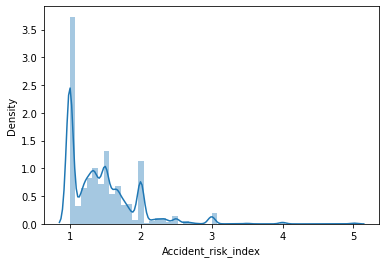

In [86]:
sns.distplot(train_tmp['Accident_risk_index'])
#sns.distplot(train_tmp['predictions'])

d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='predictions', ylabel='Density'>

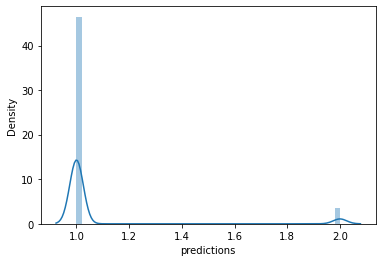

In [91]:
sns.distplot(np.round_(train_tmp['predictions']))

In [48]:
test_tmp = test_df.merge(y, on=['postcode', 'labels'], how='left')

In [243]:
y.loc[y['postcode'] == 'ZE2 9SD']

,postcode,labels,predictions
49771,ZE2 9SD,0,1.421954


In [244]:
test_tmp.loc[test_tmp['postcode'] == 'ZE2 9SD']

,postcode,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,labels,predictions
49771,ZE2 9SD,0.320241,1,2,6,1,46,12.333333,30,60,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,0,1.421954


In [479]:
#X = train_df.query("labels == 1").drop(['postcode','Accident_risk_index','labels','1st_Road_Class_1'
#                                                        ,'1st_Road_Class_3', '1st_Road_Class_4','1st_Road_Class_5','1st_Road_Class_6'
#                                                       ],axis=1)
#Y = train_df.query("labels == 1")['Accident_risk_index']
tmp_x = X
tmp_x.fillna(-999, inplace=True)
model = sm.OLS(Y, tmp_x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Accident_risk_index   R-squared (uncentered):                   0.891
Model:                             OLS   Adj. R-squared (uncentered):              0.890
Method:                  Least Squares   F-statistic:                          3.240e+04
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):                        0.00
Time:                         00:11:37   Log-Likelihood:                         -70314.
No. Observations:                95625   AIC:                                  1.407e+05
Df Residuals:                    95601   BIC:                                  1.409e+05
Df Model:                           24                                                  
Covariance Type:             nonrobust                                                  
==============================================================================================================================================================================
                                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vehicle_min                                                                                                    0.1668      0.004     43.476      0.000       0.159       0.174
vehicle_max                                                                                                    0.0748      0.003     28.612      0.000       0.070       0.080
Accident_ID                                                                                                    0.0010      0.000      2.516      0.012       0.000       0.002
police_min                                                                                                    -0.0011      0.000     -5.032      0.000      -0.001      -0.001
police_max                                                                                                     0.0010      0.000      6.765      0.000       0.001       0.001
police_mean                                                                                                    0.0023      0.000      7.558      0.000       0.002       0.003
speed_min                                                                                                      0.0106      0.000     49.094      0.000       0.010       0.011
speed_max                                                                                                      0.0046      0.000     33.811      0.000       0.004       0.005
1st_Road_Class_1                                                                                              -0.0026      0.004     -0.658      0.510      -0.010       0.005
1st_Road_Class_3                                                                                              -0.0037      0.001     -2.582      0.010      -0.007      -0.001
1st_Road_Class_4                                                                                               0.0075      0.002      4.176      0.000       0.004       0.011
1st_Road_Class_5                                                                                              -0.0032      0.002     -1.723      0.085      -0.007       0.000
1st_Road_Class_6                                                                                               0.0030      0.002      1.963      0.050     5.3e-06       0.006
Urban_or_Rural_Area_1                                                                                          0.0017      0.001      2.206      0.027       0.000       0.00

In [183]:
val_pred_dict = {'hist_pred':a, 'lin_pred':b, 'target':train_df['Accident_risk_index']}

val_pred_df = pd.DataFrame.from_dict(val_pred_dict)

In [184]:
test_pred_dict = {'hist_pred':c, 'lin_pred':d}

test_pred_df = pd.DataFrame.from_dict(test_pred_dict)

In [185]:
X = val_pred_df.drop(['target'],axis=1)
Y = val_pred_df['target']

In [186]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [187]:
rid = Ridge(random_state=42)

In [188]:
rid.fit(x_train, y_train)

Ridge(random_state=42)

In [189]:
y_pred = rid.predict(x_val)

In [190]:
mean_squared_error(y_val, y_pred)

0.240198649130098

In [191]:
test_predictions = rid.predict(test_pred_df)

In [170]:
def objective(trial):
    
    
    params_hist = {
        
        #'loss':trial.suggest_categorical("loss",["poisson","squared_error"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001,0.5),
        "max_depth":trial.suggest_int("max_depth",3,10),
        "max_iter":trial.suggest_int("max_iter",100,1000),
        "max_leaf_nodes":trial.suggest_int("max_leaf_nodes",0,31),
        "min_samples_leaf":trial.suggest_int("min_samples_leaf",20,100),
        "l2_regularization":trial.suggest_float("l2_regularization",0.1,1),
        #'scoring':"neg_root_mean_squared_error",
        #"early_stopping":50,
        'random_state':42,
        'early_stopping':50,
    }
    '''
    params_poison = {
        
        "max_iter":trial.suggest_int("max_iter",100,1000),
        "alpha": trial.suggest_float("alpha", 0.01,1),
        "tol": trial.suggest_float("tol", 0.0001,0.1),
    }
    
    
    params_knn = {
        
        "n_neighbors":trial.suggest_int("n_neighbors",5,100),
        "metric":trial.suggest_categorical("metric",["cosine","euclidean","minkowski"]),
        
        
    }
    '''
    
    
    score = train_and_evaluate_casualty(train_df.query("labels  == 4"), test_df.query("labels == 4"), params_hist, True)
    
    
    return score

In [171]:

study = optuna.create_study()
study.optimize(objective, n_jobs=4, n_trials=10)
print("Best hyperparameters: {}".format(study.best_trial.params))


[I 2022-03-22 13:09:02,513] A new study created in memory with name: no-name-b883d30f-65c5-4e25-8258-f8c9f564037d
d:\python3.9\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


Training fold 1
Training fold 1
Training fold 1
Training fold 1
 current fold rmse is 0.656031430388179
Training fold 2
 current fold rmse is 0.6645863052151149
Training fold 2
 current fold rmse is 0.656054943870809
 current fold rmse is 0.653963573104673
Training fold 2
Training fold 2
 current fold rmse is 0.6837256352876603
Training fold 3
 current fold rmse is 0.6903419477069984
Training fold 3
 current fold rmse is 0.6734426718022791
Training fold 4
 current fold rmse is 0.6839716368183705
Training fold 3
 current fold rmse is 0.7327805550995058
Training fold 5
 current fold rmse is 0.6823203920685255
Training fold 4
 current fold rmse is 0.6838711324231975
Training fold 3


[I 2022-03-22 13:09:05,981] Trial 2 finished with value: 0.6838454108214136 and parameters: {'learning_rate': 0.22397158890392033, 'max_depth': 4, 'max_iter': 644, 'max_leaf_nodes': 28, 'min_samples_leaf': 87, 'l2_regularization': 0.48763100732719}. Best is trial 2 with value: 0.6838454108214136.


 current fold rmse is 0.6707252592267066
Our out of folds mean score is 0.6838454108214136
Training fold 1
 current fold rmse is 0.6747018334656039
Training fold 4
 current fold rmse is 0.7375273504594617
Training fold 5
 current fold rmse is 0.6532477516166764
Training fold 2
 current fold rmse is 0.674213365593328
Training fold 4


[I 2022-03-22 13:09:06,697] Trial 0 finished with value: 0.6909023923809484 and parameters: {'learning_rate': 0.45640239961991547, 'max_depth': 8, 'max_iter': 475, 'max_leaf_nodes': 26, 'min_samples_leaf': 61, 'l2_regularization': 0.586957496735529}. Best is trial 2 with value: 0.6838454108214136.


 current fold rmse is 0.6774776062992193
 current fold rmse is 0.7339411104364664
 current fold rmse is 0.6833276691946893
Our out of folds mean score is 0.6909023923809484
Training fold 5
Training fold 1
Training fold 3
 current fold rmse is 0.7338069691218202
Training fold 5
 current fold rmse is 0.6734591288852291
Training fold 4
 current fold rmse is 0.7317914481787773
Training fold 5
 current fold rmse is 0.6539481020490605
Training fold 2


[I 2022-03-22 13:09:07,555] Trial 1 finished with value: 0.6845400565983626 and parameters: {'learning_rate': 0.10294208917023959, 'max_depth': 7, 'max_iter': 706, 'max_leaf_nodes': 23, 'min_samples_leaf': 22, 'l2_regularization': 0.19739976211267918}. Best is trial 2 with value: 0.6838454108214136.


 current fold rmse is 0.6714596327543121
Our out of folds mean score is 0.6845400565983626
Training fold 1
 current fold rmse is 0.669431525504742


[I 2022-03-22 13:09:07,760] Trial 3 finished with value: 0.6835968078225144 and parameters: {'learning_rate': 0.059688539586909554, 'max_depth': 4, 'max_iter': 216, 'max_leaf_nodes': 29, 'min_samples_leaf': 41, 'l2_regularization': 0.4089831511047376}. Best is trial 3 with value: 0.6835968078225144.
[I 2022-03-22 13:09:07,843] Trial 4 finished with value: 0.6825714366222175 and parameters: {'learning_rate': 0.1450569285774716, 'max_depth': 5, 'max_iter': 363, 'max_leaf_nodes': 6, 'min_samples_leaf': 93, 'l2_regularization': 0.32371800084795255}. Best is trial 4 with value: 0.6825714366222175.


Our out of folds mean score is 0.6835968078225144
 current fold rmse is 0.6684187161329762
Training fold 1
Our out of folds mean score is 0.6825714366222175
Training fold 1
 current fold rmse is 0.6590185353677074
Training fold 2
 current fold rmse is 0.6571549537537148
Training fold 2
 current fold rmse is 0.6547744141987916
Training fold 2
 current fold rmse is 0.6862268475532513
Training fold 3
 current fold rmse is 0.6844112076236366
Training fold 3
 current fold rmse is 0.6829421736389507
Training fold 3
 current fold rmse is 0.6766281834988602
 current fold rmse is 0.6741383976205406
Training fold 4
Training fold 4
 current fold rmse is 0.7327563491134393
Training fold 5
 current fold rmse is 0.7368770393749963
Training fold 5
 current fold rmse is 0.6841110225428615
Training fold 3
 current fold rmse is 0.6739932064339165
Training fold 4
 current fold rmse is 0.6706722274955442
Our out of folds mean score is 0.6843196646904389

[I 2022-03-22 13:09:10,276] Trial 7 finished with value: 0.6843196646904389 and parameters: {'learning_rate': 0.20703220142718523, 'max_depth': 10, 'max_iter': 299, 'max_leaf_nodes': 15, 'min_samples_leaf': 74, 'l2_regularization': 0.4661649496405128}. Best is trial 4 with value: 0.6825714366222175.



Training fold 1
 current fold rmse is 0.6748613391056129
Training fold 4
 current fold rmse is 0.6744200162046352


[I 2022-03-22 13:09:10,514] Trial 6 finished with value: 0.6871489713856173 and parameters: {'learning_rate': 0.2701571104581396, 'max_depth': 6, 'max_iter': 292, 'max_leaf_nodes': 26, 'min_samples_leaf': 28, 'l2_regularization': 0.8582821857986301}. Best is trial 4 with value: 0.6825714366222175.


Our out of folds mean score is 0.6871489713856173
 current fold rmse is 0.7336984939235889
Training fold 5
 current fold rmse is 0.7325126679683851
 current fold rmse is 0.6540406346549331
Training fold 5
Training fold 2


[I 2022-03-22 13:09:11,628] Trial 8 finished with value: 0.6839124670253358 and parameters: {'learning_rate': 0.06513908535614885, 'max_depth': 6, 'max_iter': 181, 'max_leaf_nodes': 12, 'min_samples_leaf': 41, 'l2_regularization': 0.7744135874404223}. Best is trial 4 with value: 0.6825714366222175.


 current fold rmse is 0.669471867298568
Our out of folds mean score is 0.6839124670253358
 current fold rmse is 0.6831815622337483
Training fold 3
 current fold rmse is 0.6740080291158044
Training fold 4


[I 2022-03-22 13:09:12,631] Trial 5 finished with value: 0.6827693838336164 and parameters: {'learning_rate': 0.01715312229513831, 'max_depth': 3, 'max_iter': 387, 'max_leaf_nodes': 4, 'min_samples_leaf': 82, 'l2_regularization': 0.7143486582121228}. Best is trial 4 with value: 0.6825714366222175.


 current fold rmse is 0.6678101330027751
 current fold rmse is 0.7335668857920286
Training fold 5
Our out of folds mean score is 0.6827693838336164


[I 2022-03-22 13:09:13,063] Trial 9 finished with value: 0.683084342648925 and parameters: {'learning_rate': 0.027439272278448258, 'max_depth': 10, 'max_iter': 556, 'max_leaf_nodes': 3, 'min_samples_leaf': 45, 'l2_regularization': 0.9684567580067605}. Best is trial 4 with value: 0.6825714366222175.


 current fold rmse is 0.667912941828059
Our out of folds mean score is 0.683084342648925
Best hyperparameters: {'learning_rate': 0.1450569285774716, 'max_depth': 5, 'max_iter': 363, 'max_leaf_nodes': 6, 'min_samples_leaf': 93, 'l2_regularization': 0.32371800084795255}


In [49]:
test_tmp

,postcode,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,...,Urban_or_Rural_Area_1,Urban_or_Rural_Area_2,winter_0,winter_1,daylight_0,daylight_1,Did_Police_Officer_Attend_Scene_of_Accident_No,Did_Police_Officer_Attend_Scene_of_Accident_Yes,labels,predictions
0,AB10 1AU,0.0,1,1,1,14,14,14.000000,30,30,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4,1.412139
1,AB10 1PG,0.0,1,1,2,1,11,6.000000,30,60,...,1.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,4,1.423986
2,AB10 1TT,0.0,2,2,1,15,15,15.000000,30,30,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,4,1.467852
3,AB10 1YP,0.0,2,2,3,1,43,18.333333,20,30,...,3.0,0.0,2.0,1.0,3.0,0.0,1.0,2.0,0,1.378864
4,AB10 6LQ,0.0,2,2,1,47,47,47.000000,30,30,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2,1.384211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49767,ZE2 9LZ,0.0,2,2,1,1,1,1.000000,30,30,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4,1.387167
49768,ZE2 9RE,0.0,1,2,4,1,14,4.250000,30,40,...,4.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,4,1.409367
49769,ZE2 9RJ,0.0,2,2,1,1,1,1.000000,30,30,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,4,1.361291
49770,ZE2 9SB,0.0,2,2,1,15,15,15.000000,30,30,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4,1.460205


,postcode,labels,predictions
3,AB10 1YP,0,1.378864
9,AB11 5BD,0,1.338033
13,AB11 5PA,0,1.442537
28,AB11 9PE,0,1.364262
32,AB12 3JB,0,1.458545
...,...,...,...
49765,YO8 9XB,4,1.452036
49767,ZE2 9LZ,4,1.387167
49768,ZE2 9RE,4,1.409367
49769,ZE2 9RJ,4,1.361291


In [44]:
test_df['Accident_risk_index'] = y

ValueError: Columns must be same length as key

In [494]:
test_df.loc[(test_df['Accident_ID'] == 1) & (test_df['vehicle_max'] == 1), "Accident_risk_index"] = 1

In [508]:
train_df.loc[(train_df['Accident_ID'] == 1) & (train_df['vehicle_max'] == 1),['Accident_risk_index','postcode_x']].value_counts()

Accident_risk_index  postcode_x
1.0                  AB10 6BQ      1
                     TW2 7AS       1
                     TW2 5JF       1
                     TW2 5BD       1
                     TW18 3JE      1
                                  ..
                     LE13 0GL      1
                     LE12 8TN      1
                     LE12 5RY      1
                     LE11 5RF      1
5.0                  WR10 3HG      1
Length: 5781, dtype: int64

In [509]:
train.loc[train.postcode == 'WR10 3HG']

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country,Month,year,day,Time_split,daylight,winter
327113,409864,53,1,5,2012-12-20,3,7:40,22,W06000023,3,...,Yes,England,WR10 3HG,United Kingdom,12,2012,20,7,0,1


In [417]:
test_df.describe()

,Accident_risk_index,vehicle_min,vehicle_max,Accident_ID,police_min,police_max,police_mean,speed_min,speed_max,1st_Road_Class_1,...,Did_Police_Officer_Attend_Scene_of_Accident_Yes,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value,high_risk_sector
count,49772.000000,49772.000000,49772.000000,49772.000000,49772.000000,49772.000000,49772.000000,49772.000000,49772.000000,49772.000000,...,49772.000000,18899.000000,18899.000000,18899.000000,18899.000000,18899.000000,18899.000000,18899.000000,18899.000000,49530.000000
mean,1.413805,1.577132,1.960239,2.436289,8.794483,19.832255,13.162743,31.535000,37.283814,0.009765,...,2.031584,7491.834700,3673.644373,3818.190328,7370.515424,121.319276,91.249802,2676.956815,23.322065,0.531435
std,0.071245,0.561553,0.560361,2.143760,14.127916,19.649610,14.073088,8.332136,12.435362,0.098741,...,1.909362,3505.605638,1721.293595,1790.993682,3473.455880,245.558628,53.492387,4471.320094,32.000053,0.499016
min,1.263491,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,20.000000,0.000000,...,0.000000,121.000000,53.000000,44.000000,121.000000,0.000000,0.000000,0.380000,0.000000,0.000000
25%,1.368240,1.000000,2.000000,1.000000,1.000000,5.000000,4.000000,30.000000,30.000000,0.000000,...,1.000000,4930.000000,2421.000000,2501.000000,4840.000000,22.000000,52.000000,233.710000,1.800000,0.000000
50%,1.424285,2.000000,2.000000,2.000000,1.000000,14.000000,10.000000,30.000000,30.000000,0.000000,...,1.000000,7300.000000,3587.000000,3727.000000,7144.000000,61.000000,82.000000,649.720000,11.900000,1.000000
75%,1.463653,2.000000,2.000000,3.000000,13.000000,34.000000,15.000000,30.000000,40.000000,0.000000,...,3.000000,9711.000000,4752.000000,4959.000000,9580.000000,129.000000,121.000000,3323.540000,32.900000,1.000000
max,1.651910,4.000000,4.000000,18.000000,98.000000,98.000000,98.000000,70.000000,70.000000,2.000000,...,17.000000,20955.000000,10467.000000,10618.000000,20955.000000,5627.000000,403.000000,43683.760000,513.400000,1.000000


d:\python3.9\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Accident_risk_index', ylabel='Density'>

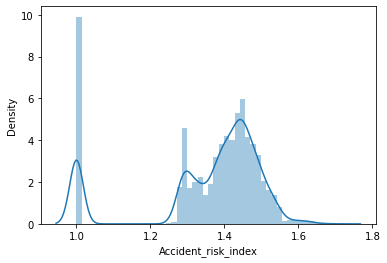

In [496]:
sns.distplot(test_df['Accident_risk_index'])

In [248]:
#test_df['Accident_risk_index'] = test_df['Number_of_Casualties'] / test_df['Accident_ID']

In [51]:
submission_df = test_tmp[['postcode','predictions']]

In [52]:
submission_df.columns = ['postcode','Accident_risk_index']

In [53]:
submission_df.to_csv('my_submission_v19.csv', index=False)

In [500]:
submission_df.shape

(49772, 2)

In [501]:
submission_df

,postcode,Accident_risk_index
0,AB10 1AU,1.000000
1,AB10 1PG,1.421610
2,AB10 1TT,1.488124
3,AB10 1YP,1.382699
4,AB10 6LQ,1.337028
...,...,...
49767,ZE2 9LZ,1.320769
49768,ZE2 9RE,1.394107
49769,ZE2 9RJ,1.288639
49770,ZE2 9SB,1.461229
